In [194]:
import requests
import pandas as pd

def get_power_data(lat, lon, start, end):

  BASE_URL = "https://power.larc.nasa.gov/api/temporal/daily/point"
  params = {
        "start": start,
        "end": end,
        "latitude": lat,
        "longitude": lon,
        "community": "AG",
        "parameters": "T2M_MAX,PRECTOTCORR,WS2M,RH2M", # Variables: max temp, precipitation, wind speed, humidity
        "format": "JSON"
    }


  # Call API
  response = requests.get(BASE_URL, params=params)
  data = response.json()

  # Extract data
  df = pd.DataFrame(data['properties']['parameter'])
  df = df.transpose()  # Transpose so dates become rows

  return df


In [195]:
df = get_power_data(40.7128, -74.0060, "20190101", "20191230")
print(df)

             20190101  20190102  20190103  20190104  20190105  20190106  \
T2M_MAX         12.29      4.47      5.95      6.49      7.06      7.73   
PRECTOTCORR      1.02      0.04      0.68      0.71     24.98      0.16   
WS2M             6.82      3.49      4.14      4.08      5.52      6.26   
RH2M            85.21     72.53     82.39     85.74     93.86     81.41   

             20190107  20190108  20190109  20190110  ...  20191221  20191222  \
T2M_MAX          2.19      6.99      7.15      1.23  ...      2.15      5.95   
PRECTOTCORR      0.00      3.44      4.98      0.29  ...      0.00      0.00   
WS2M             4.48      3.01      8.05      8.78  ...      2.12      4.26   
RH2M            71.77     93.12     79.97     77.37  ...     82.32     85.84   

             20191223  20191224  20191225  20191226  20191227  20191228  \
T2M_MAX          8.21      6.55      6.81      6.98      9.74      8.47   
PRECTOTCORR      0.00      0.00      0.00      0.04      0.18      0.01  

# 1. Importing the dependencies

In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import  RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# 2. Data Collection and Processing

In [197]:
# Load the dataset
data=df
data.head()

,20190101,20190102,20190103,20190104,20190105,20190106,20190107,20190108,20190109,20190110,...,20191221,20191222,20191223,20191224,20191225,20191226,20191227,20191228,20191229,20191230
T2M_MAX,12.29,4.47,5.95,6.49,7.06,7.73,2.19,6.99,7.15,1.23,...,2.15,5.95,8.21,6.55,6.81,6.98,9.74,8.47,7.21,7.76
PRECTOTCORR,1.02,0.04,0.68,0.71,24.98,0.16,0.00,3.44,4.98,0.29,...,0.00,0.00,0.00,0.00,0.00,0.04,0.18,0.01,14.59,34.04
WS2M,6.82,3.49,4.14,4.08,5.52,6.26,4.48,3.01,8.05,8.78,...,2.12,4.26,4.43,4.54,1.99,3.08,3.30,2.92,3.22,6.99
RH2M,85.21,72.53,82.39,85.74,93.86,81.41,71.77,93.12,79.97,77.37,...,82.32,85.84,92.74,83.72,82.22,93.36,92.39,86.62,87.16,96.10


In [198]:
df.loc["DATE"] = df.columns


In [199]:
data=data.T

In [200]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, 20190101 to 20191230
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   T2M_MAX      364 non-null    object
 1   PRECTOTCORR  364 non-null    object
 2   WS2M         364 non-null    object
 3   RH2M         364 non-null    object
 4   DATE         364 non-null    object
dtypes: object(5)
memory usage: 25.2+ KB


In [201]:
data.shape

(364, 5)

In [202]:
print("Missing values in each column:")
print(data.isnull().sum())

Missing values in each column:
T2M_MAX        0
PRECTOTCORR    0
WS2M           0
RH2M           0
DATE           0
dtype: int64


In [203]:
data.head()

,T2M_MAX,PRECTOTCORR,WS2M,RH2M,DATE
20190101,12.29,1.02,6.82,85.21,20190101
20190102,4.47,0.04,3.49,72.53,20190102
20190103,5.95,0.68,4.14,82.39,20190103
20190104,6.49,0.71,4.08,85.74,20190104
20190105,7.06,24.98,5.52,93.86,20190105


# 3. EDA - Exploratory Data Analysis

In [204]:
data.shape

(364, 5)

In [205]:
# setting the plot style
sns.set(style="whitegrid")

In [206]:
data.describe()

,T2M_MAX,PRECTOTCORR,WS2M,RH2M,DATE
count,364.00,364.0,364.00,364.00,364
unique,348.00,212.0,272.00,347.00,364
top,7.46,0.0,3.47,83.72,20191230
freq,2.00,69.0,5.00,2.00,1


In [207]:
data.columns

Index(['T2M_MAX', 'PRECTOTCORR', 'WS2M', 'RH2M', 'DATE'], dtype='object')

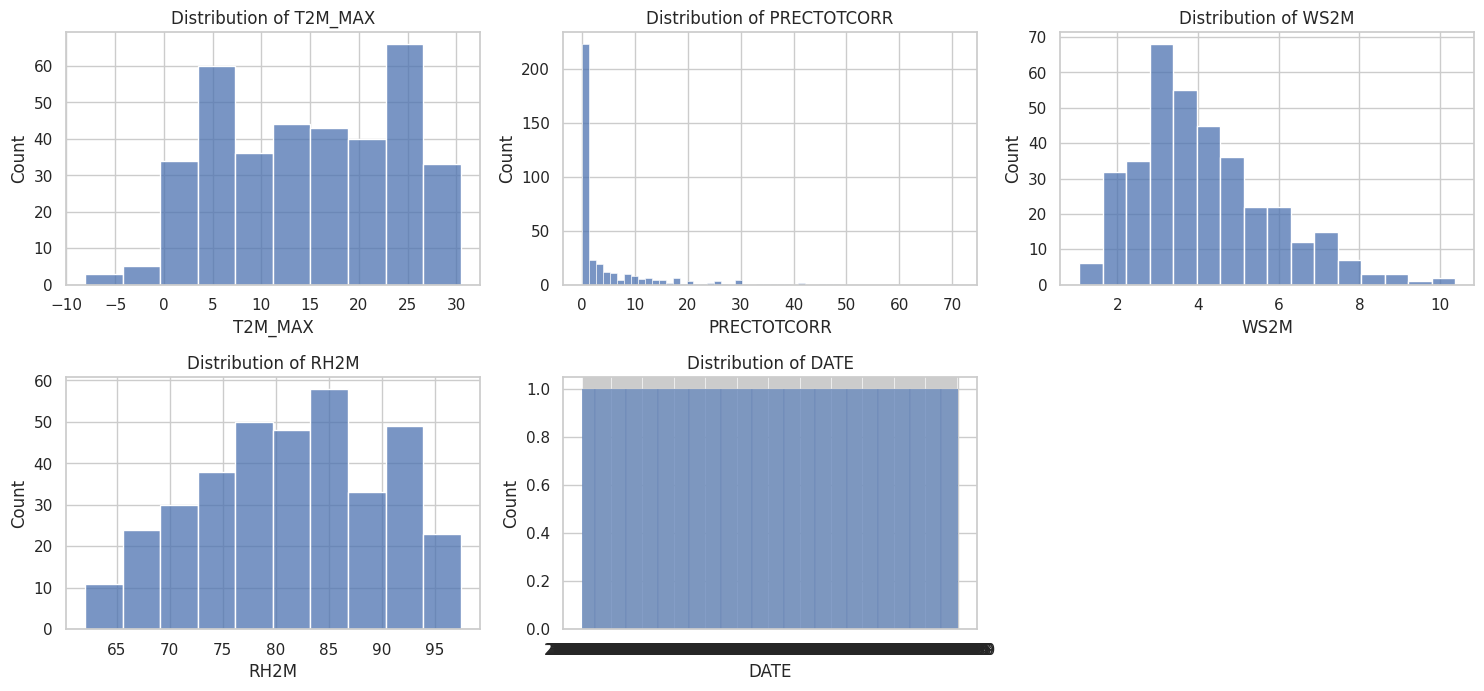

In [208]:
cols = data.columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(cols):
    plt.subplot(3, 3, i+1)  # i+1 because subplot index starts at 1
    sns.histplot(data[col])
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Rainfall Distribution')

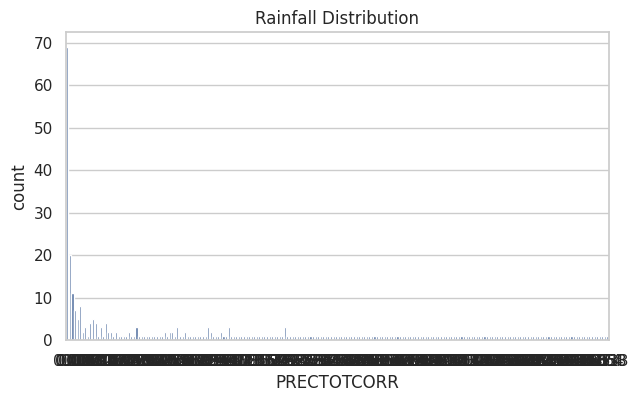

In [209]:
plt.figure(figsize=(7, 4))
sns.countplot(x='PRECTOTCORR', data=data)
plt.title('Rainfall Distribution')


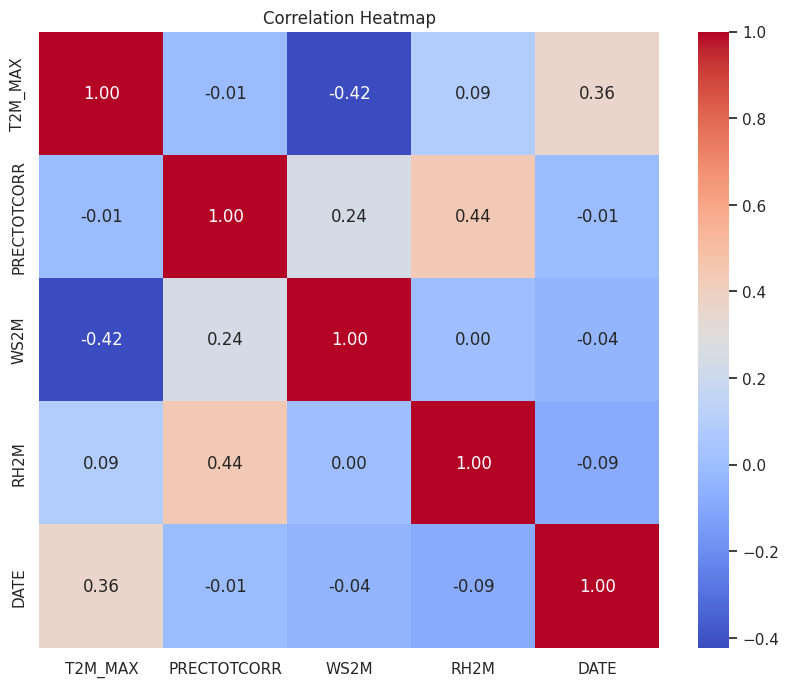

In [210]:
# correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

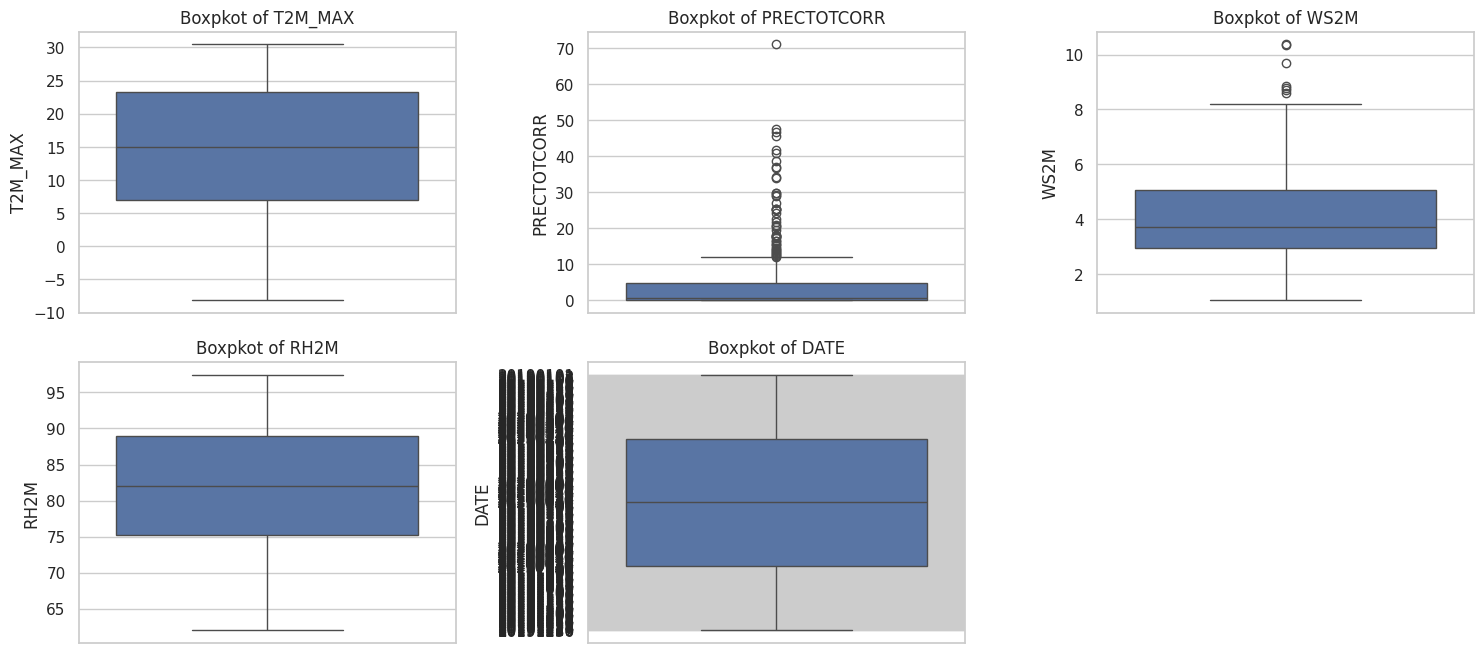

In [211]:
# checking for outliers using boxplots

cols = data.columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(cols):
    plt.subplot(3, 3, i+1)  # i+1 because subplot index starts at 1
    sns.boxplot(data[col])
    plt.title(f'Boxpkot of {col}')
plt.tight_layout()
plt.show()

# 4. Data Preprocessing

In [212]:
# drop the multicollinearity columns
data = data.drop(columns=['T2M_MAX'])

In [213]:
data["rainfall"] = (data["PRECTOTCORR"] > 0.2).astype(int)

In [214]:
data.head(10)

,PRECTOTCORR,WS2M,RH2M,DATE,rainfall
20190101,1.02,6.82,85.21,20190101,1
20190102,0.04,3.49,72.53,20190102,0
20190103,0.68,4.14,82.39,20190103,1
20190104,0.71,4.08,85.74,20190104,1
20190105,24.98,5.52,93.86,20190105,1
20190106,0.16,6.26,81.41,20190106,0
20190107,0.0,4.48,71.77,20190107,0
20190108,3.44,3.01,93.12,20190108,1
20190109,4.98,8.05,79.97,20190109,1
20190110,0.29,8.78,77.37,20190110,1


In [215]:
print(data["rainfall"].value_counts())

rainfall
1    209
0    155
Name: count, dtype: int64


In [216]:
# separate majority and minority classes
df_majority = data[data['rainfall'] == 1]
df_minority = data[data['rainfall'] == 0]
print("Majority class shape:", df_majority.shape)
print("Minority class shape:", df_minority.shape)

Majority class shape: (209, 5)
Minority class shape: (155, 5)


In [217]:
# downsample the majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False, n_samples=len(df_minority),
                                   random_state=42)


In [218]:
df_majority_downsampled.shape

(155, 5)

In [219]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled.shape
df_downsampled.tail()

,PRECTOTCORR,WS2M,RH2M,DATE,rainfall
20191224,0.0,4.54,83.72,20191224,0
20191225,0.0,1.99,82.22,20191225,0
20191226,0.04,3.08,93.36,20191226,0
20191227,0.18,3.3,92.39,20191227,0
20191228,0.01,2.92,86.62,20191228,0


In [220]:
# shuffle the dataset
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)
df_downsampled.head()

,PRECTOTCORR,WS2M,RH2M,DATE,rainfall
0,0.0,4.12,75.84,20191121,0
1,11.89,7.8,95.63,20191202,1
2,2.8,2.82,93.68,20190503,1
3,0.47,5.81,76.34,20190825,1
4,5.24,2.76,88.33,20190819,1


In [221]:
df_downsampled["rainfall"].value_counts()

,count
rainfall,
0,155
1,155


In [222]:
# Split the dataset into features and target variable
X = df_downsampled.drop(columns=['rainfall'])
y = df_downsampled['rainfall']

In [223]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Model Training

In [224]:
rf = RandomForestClassifier( random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [225]:
# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/uti

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [226]:
best_rf = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


# 6. Model Evaluation

In [227]:
cv_score = cross_val_score(best_rf, X_train, y_train, cv=5)
print("Cross-validation scores: ", cv_score)
print("Mean cross-validation score: ", np.mean(cv_score))

Cross-validation scores:  [1.         1.         1.         1.         0.97959184]
Mean cross-validation score:  0.9959183673469388


In [228]:
# test the model on the test set
y_pred = best_rf.predict(X_test)
print("Test set accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Test set accuracy:  1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        31

    accuracy                           1.00        62
   macro avg       1.00      1.00      1.00        62
weighted avg       1.00      1.00      1.00        62

Confusion Matrix:
 [[31  0]
 [ 0 31]]


In [229]:
# save the model
joblib.dump(best_rf, 'rainfall_prediction_model.pkl')

['rainfall_prediction_model.pkl']

# 7. Prediction system

In [230]:
# load the model
loaded_model = joblib.load('rainfall_prediction_model.pkl')

In [231]:
#T2M_MAX-->removed 	#PRECTOTCORR	WS2M	RH2M	DATE
input_data = {
    "PRECTOTCORR": 0.7,
    "WS2M": 3.1,
    "RH2M": 85,
    "DATE": 20190709,
}
df = pd.DataFrame([input_data])
df.head()

,PRECTOTCORR,WS2M,RH2M,DATE
0,0.7,3.1,85,20190709


In [232]:
prediction = loaded_model.predict(df)
if prediction[0] == 1:
    print("Rain is expected.")
else:
    print("No rain is expected.")

Rain is expected.
